# Final Project: Analysis of GW200129

For this assignment, you will have to conduct an analysis of the gravitational-wave signal GW200129_065458 (thereafter simply GW200129). This analysis should be done within a Jupyter notebook, with many comments in [Markdown](https://colab.research.google.com/notebooks/markdown_guide.ipynb) desribing and **justifying** the steps taken.

- The writing should be at the level of a fellow student of the class
- Describe **in details** every step of your analysis throughout the notebook.
- Any setting choice (sampling rate, window parameter, FFT length, etc...) needs to be justified, either by its own investigation or relevant citations from the literature.
- Code alone, without a detailed descriptions of what is done and why, is worth at most half marks.
- Remember to re-run your notebook from scratch after a kernel re-start before submission.

NOTE: you can use any of the notebooks covered in the class, or code available online, _provided that you justify the settings and methods used_.

## Introduction (15 points)
Minimum 300 words.
- Write an introduction to this analysis, citing the relevant context and literature.
- Write a short summary of what is done in the notebook.

In [197]:
import numpy as np
import matplotlib.pyplot as plt


In [198]:
!pip install -q gwpy

In [199]:
! pip install -q lalsuite pycbc

In [200]:
from scipy.signal import get_window

In [201]:
from gwosc.datasets import event_gps

In [202]:
from gwpy.timeseries import TimeSeries

## The data and noise model (10 points)

- Download and plot the relevant gravitational-wave data for GW200129.
- Compute and plot the Power Spectrum Density. (chapter 5)
- Compute and plot the whitened data. Use filters if necessary to best highlight where the signal is (or might be).

In [203]:
gps = event_gps("GW200129_065458") #finds time centre of GW200129
start = int(gps) -512
end = int(gps) + 512 # sets the start and end of the event as +- 15 seconds from the time centre

In [204]:
print(gps)

1264316116.4


In [205]:
GW_200129_strain_H1 = TimeSeries.fetch_open_data('H1', start, end) #fetches the time series from H1
GW_200129_strain_L1 = TimeSeries.fetch_open_data('L1', start, end) #fetches the time series from L1

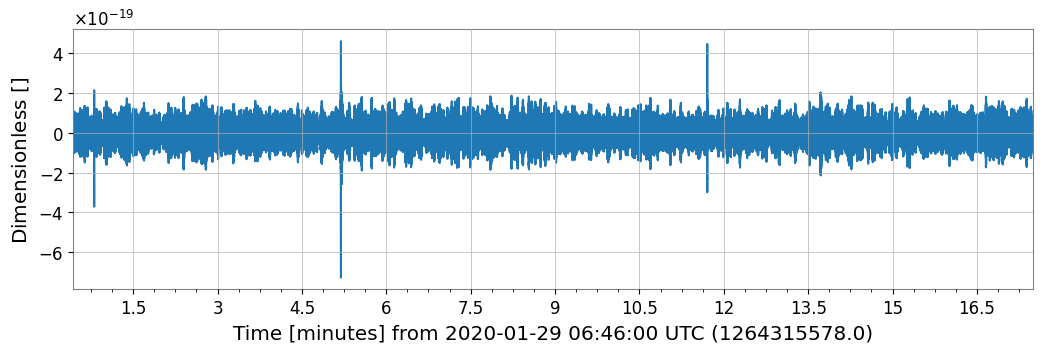

In [206]:

H1_strain = GW_200129_strain_H1.plot()



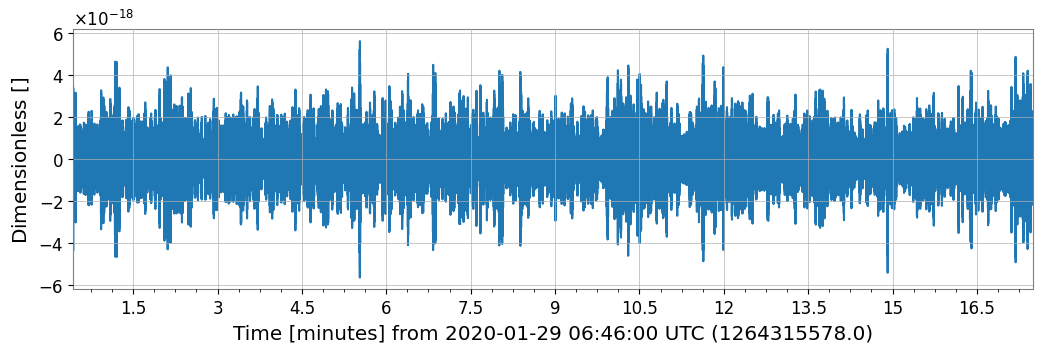

In [207]:
L1_strain = GW_200129_strain_L1.plot()

In [208]:
normalised_fft=GW_200129_strain_H1.average_fft(window=('tukey',1./4.))*(GW_200129_strain_H1.duration.value/2)

/usr/local/lib/python3.11/dist-packages/gwpy/plot/axes.py:194: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  super().draw(*args, **kwargs)


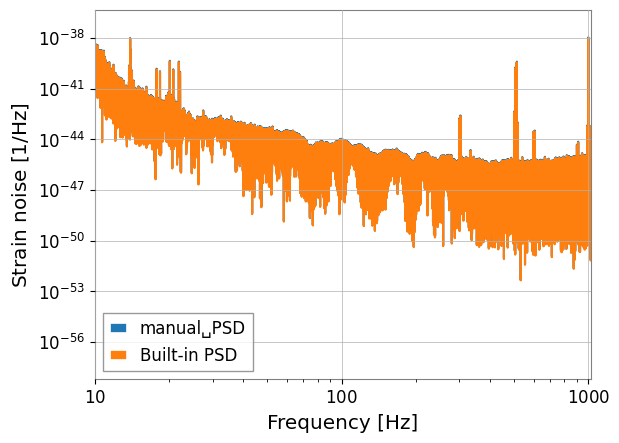

In [209]:
plt.loglog((2/GW_200129_strain_H1.duration.value)*np.abs(normalised_fft)**2,label='manual␣PSD')
plt.loglog(GW_200129_strain_H1.psd(window=('tukey',1./4.)),label='Built-in PSD')
plt.ylabel('Strain noise [$1/\mathrm{Hz}$]')
plt.xlabel('Frequency [Hz]')
plt.xlim(10,1024)
plt.legend();

In [210]:
strain_H1_white = GW_200129_strain_H1.whiten(fftlength=4,overlap=2,window=('tukey',1./4.))
# Getting a more manageable 32 seconds of data:
strain_white=strain_H1_white.crop(gps - 16,gps+ 16)

Text(0.5, 0, 'time [s]')

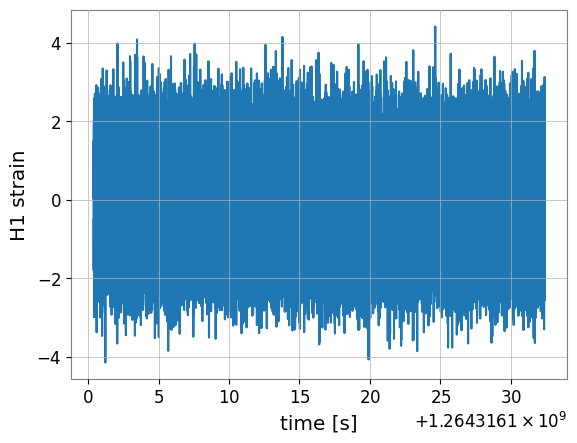

In [211]:
plt.plot(strain_white)
#plt.xlim(gps+0.25,gps+0.46)
plt.ylabel('H1 strain')
plt.xlabel('time [s]')

'The rate of glitches at frequencies similar to the signal is much lower; using data from 4 days around the event, the rate of glitches with frequency 60-120 Hz is only 0.06/hr.'

In [212]:
# Badpassing the whitened strain with specific values are defined in the detection paper (will look up lol)
strain_bp=strain_white.bandpass(60.,120.)

Text(0.5, 0, 'time [s]')

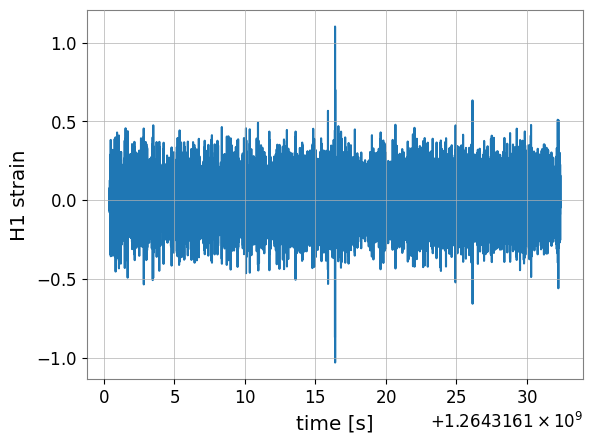

In [213]:
plt.plot(strain_bp)
#plt.xlim(gps+0.15,gps-0.05)
plt.ylabel('H1 strain')
plt.xlabel('time [s]')

Obvious peak present after band passing

Text(0.5, 0, 'time [s]')

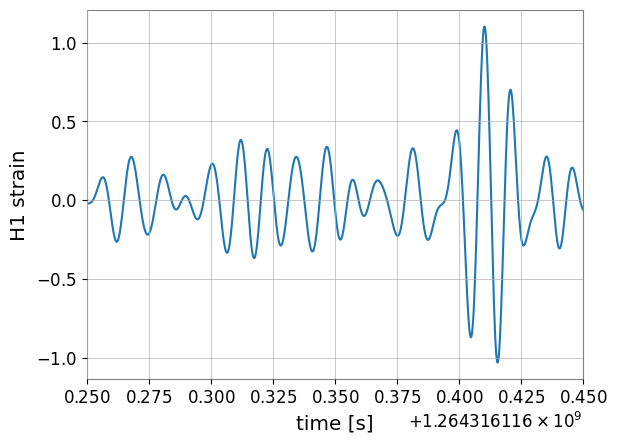

In [214]:
plt.plot(strain_bp)
plt.xlim(gps-0.15,gps+0.05)
plt.ylabel('H1 strain')
plt.xlabel('time [s]')

## The signal model (10 points)

- Generate and plot a CBC signal which you expect to be a good match for the signal. Use the literature, and cite your sources
- Generate and plot a phenomenological model (sometimes refer to as a "Burst" model). A model whose parameters describe the shape of the waveform itself, not the source.
- Plot those those two signals together, and try to find _by eye_ parameters that maximises that overlap. Discuss.

Some good sources might be pycbc and the paper about the GW event itself. GWSOC has the parameters associated with the event.

NOTE: remember that gravitational-wave are redshifted.

In [215]:
import pycbc
from pycbc.waveform import get_td_waveform

In [216]:
strain_bp=strain_white.bandpass(60.,120.).crop(gps-0.15,gps+0.05)

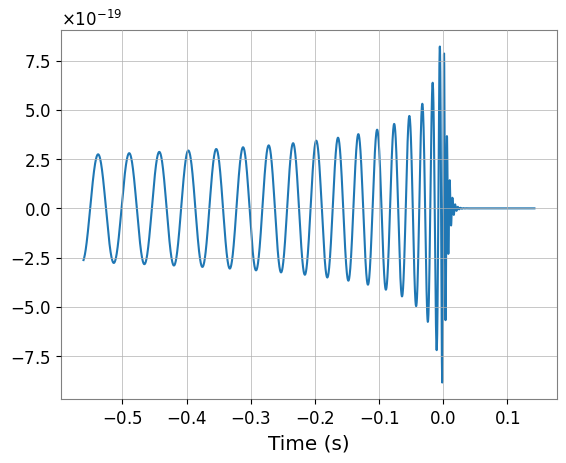

In [217]:
'''
I could definitely add distance
'''
m1 = 34.5 * (1 + 0.18)
m2 = 29 * (1 + 0.18)
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
mass1=m1,
mass2=m2,
delta_t=1./GW_200129_strain_H1.sample_rate.to_value(),
f_lower=20)

plt.plot(hp.sample_times, hp)
plt.xlabel('Time (s)');

#hp.start_time = gps + 0.01

Needs to be scaled

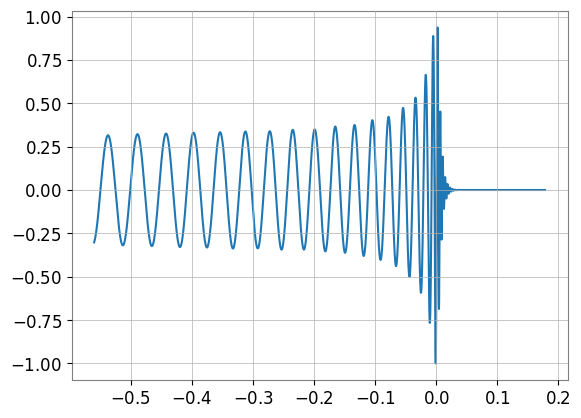

In [242]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform

# Define masses with correction factor
m1 = 34.5 * (1 + 0.18)
m2 = 29 * (1 + 0.18)

# Define sample rate (ensure GW_200129_strain_H1.sample_rate is defined)
delta_t = 1. / GW_200129_strain_H1.sample_rate.to_value()

# Generate waveform
hp, hc = get_td_waveform(approximant="SEOBNRv4PHM",
                          mass1=m1,
                          mass2=m2,
                          delta_t=delta_t,
                          spin1x=0.9,
                          f_lower=20)

# Find the current peak strain (you could adjust this to your expected peak)
# Convert hp to a NumPy array before calling np.max
current_peak = np.max(np.abs(hp.numpy()))


# Define the desired peak strain (e.g., we want it to be 1)
desired_peak = 1.0

# Calculate the scaling factor
scaling_factor = desired_peak / current_peak

# Apply the scaling factor to the waveform
hp_scaled = hp * scaling_factor

# Plot the scaled waveform
plt.plot(hp.sample_times, hp_scaled)

hp.start_time = gps - 0.545

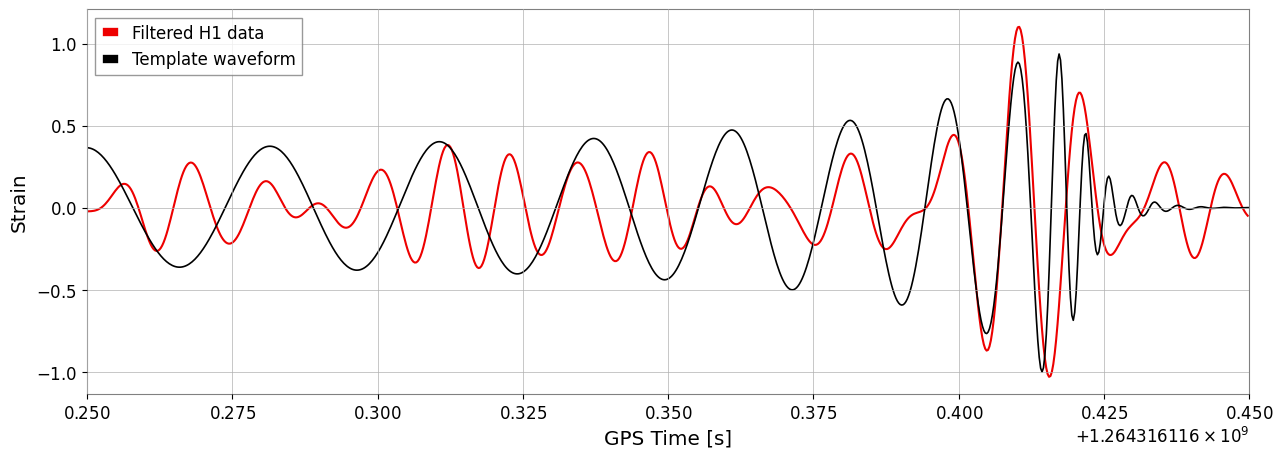

In [243]:
plt.figure(figsize=(15,5))
plt.plot(strain_bp.times,strain_bp,label='Filtered H1 data', color='gwpy:ligo-hanford')
#plt.plot(hp.sample_times,hp,label='template')
plt.plot(hp.sample_times, hp_scaled, label='Template waveform', color='black', linewidth=1.2)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.xlim(gps-0.15,gps+0.05)
#plt.ylim(-5e-22, 5e-22)
plt.legend()

In [220]:
print(f"Waveform duration: {hp.duration:.3f} s")

Waveform duration: 0.703 s


In [221]:
from scipy.signal import gausspulse

In [222]:
t0 = hp.sample_times[np.argmax(np.abs(hp))] # gives time hp reaches maximum value

In [223]:
time_shifted = hp.sample_times - t0 #shifts gaussian to the right time

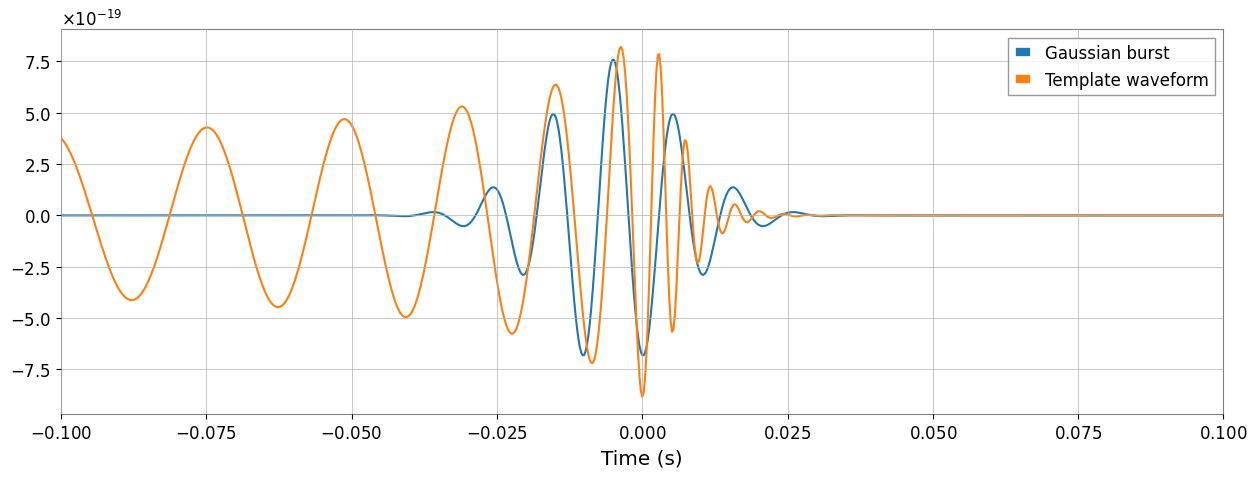

In [224]:
plt.figure(figsize=(15, 5))
plt.plot(time_shifted, gausspulse(time_shifted + 0.005, fc=95, bw=0.35)*7.6e-19, label='Gaussian burst')
plt.plot(time_shifted, hp, label='Template waveform')
plt.xlabel('Time (s)')
plt.legend()
plt.xlim(-0.1, 0.1)
plt.show()

Need to maximise the overlap between the two i think

## Detection (25 points)
Limiting yourself to a coincident (**not** coherent) analysis:
- Compute the SNR time series for the CBC signal model
- Compute the SNR time series for the Burst signal model
- Discuss the differences, if any.
- Estimate a bound on the False Alarm Rate of the detection.

In [225]:
import astropy.units as u

from gwpy.timeseries import TimeSeries as GWTimeSeries

In [244]:
from pycbc.types import TimeSeries

# Generate waveform
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m1,
                         mass2=m2,
                         delta_t=delta_t,
                         f_lower=20)

# Set target total duration (e.g., 32s centered at 0)
target_duration = 32
half_duration = target_duration / 2

# Calculate current waveform span
start = hp_scaled.start_time.gpsSeconds  # Convert to seconds
end = start + len(hp_scaled) * hp_scaled.delta_t

# Compute safe padding (in samples)
prepad = max(0, int(round((half_duration + start) / hp_scaled.delta_t)))
postpad = max(0, int(round((half_duration - end) / hp_scaled.delta_t)))

# Pad without touching start_time manually
hp_scaled.prepend_zeros(prepad)
hp_scaled.append_zeros(postpad)

# Convert to TimeSeries (now has safe handling)
template = TimeSeries(hp_scaled.data, delta_t=hp_scaled.delta_t)
template.start_time = -half_duration  # assign relative time safely

print(f"New duration: {template.duration}")  # Should be ~32.0

New duration: 32.0


In [245]:
peak_index = GW_200129_strain_H1.argmax()
peak_time = GW_200129_strain_H1.times[peak_index] # Use .times instead of .sample_times
print(f"Peak time of the signal: {peak_time}") #finds peak time of data

Peak time of the signal: 1264315889.642334 s


In [246]:

strain_H1_32 = GW_200129_strain_H1.crop(peak_time - 16*u.s, peak_time + 16*u.s) #puts into 32 second window

In [247]:
print(strain_H1_32.duration)

32.0 s


In [248]:
print(strain_H1_32.max())

4.6112755794433e-19


In [249]:
# FFT of the data, with the appropriate normalisation
data_fft=strain_H1_32.average_fft(window=('tukey',1./4.))*(strain_H1_32.duration/2)

In [250]:
# Convert pycbc.types.TimeSeries to gwpy.timeseries.TimeSeries
from gwpy.timeseries import TimeSeries as GWTimeSeries

template = GWTimeSeries(template.data, dt=template.delta_t, t0=template.start_time.gpsSeconds)

# Now you can use average_fft
template_fft = template.average_fft(window=('tukey', 1./4.)) * (template.duration / 2)

In [251]:
# We will need the PSD with the same frequency spacing as the data and template,
# so we interpolate it to match:

Pxx_H1 = GW_200129_strain_H1.psd(window=('tukey',1./4.))

Pxx_H1_32=Pxx_H1.interpolate(data_fft.df.value)

In [252]:
# With the right normalisation, this is equation 7.58 of the textbook:
optimal=data_fft*template_fft.conjugate()/Pxx_H1_32
opt_time=2*optimal.ifft()*(optimal.df*2)

In [253]:
# This is equation 7.49 of the textbook: the overlap of the template with itself
sigmasq = 4 * np.real((template_fft * template_fft.conjugate() / Pxx_H1_32).sum() *template_fft.df)
sigma = np.sqrt(np.abs(sigmasq))
# And now we have the SNR time series:
SNR_complex = opt_time/sigma

In [254]:
# We can recenter thing with the location of peak in the template:
peaksample = template.argmax()
SNR_complex = np.roll(SNR_complex,peaksample)
SNR = abs(SNR_complex)

In [255]:
SNRmax=SNR.max().value
time_max=SNR.times[SNR.argmax()]
print('Maximum SNR of {} at {}.'.format(SNRmax,time_max))

Maximum SNR of 14588.23885262793 at 1264315874.2578125 s.


Text(0, 0.5, 'SNR')

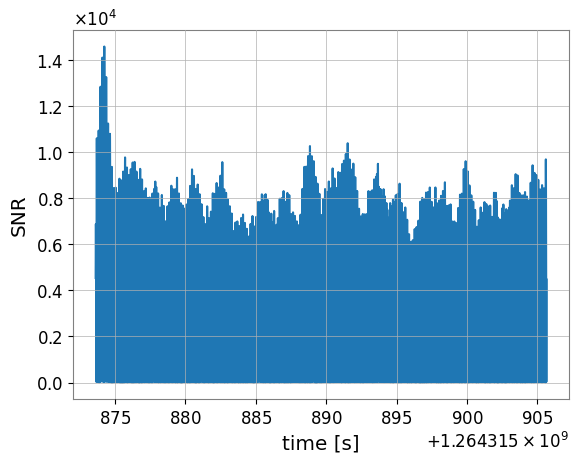

In [256]:
plt.plot(SNR.times,SNR)
plt.xlabel('time [s]')
plt.ylabel('SNR')


## Parameter Estimation (25 points)
Moving to a **coherent** analysis:
- Using the CBC model, build likelihood, prior and posterior functions for the network of gravitational-wave detectors.
- Maximise the likelihood function and plot relevant quantities.
- Interface the posterior function with a sampling algorithm.
    - You are free to select any ready-made algorithm, or write your own.
- Perform the sampling, and plot the results.
    -  This step can take a long time, and so it is best to develop and test first with a few sampling iterations, and not with the whole sampling run.
- Compare the results with the literature and discuss.

## Conclusions (15 points)
Minimum 300 words.
- Discuss your results in the context of the literature.
- Mention how your work compares with published results.
- Discuss some of the interpretation possibles of GW200129, including relevant citations from the literature, and summarising them.